### References:

https://github.com/ejmejm/multilingual-nmt-mt5/blob/main/nmt_full_version.ipynb

https://github.com/zhangmegan/LING-380-Final-Project/tree/9d9bb07fcfcf05fa45942276de5af1265b4f3701/japanese_turkish_finetuning.py

In [ ]:
import sys
import os
import re
import time
from tqdm import tqdm


# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"
os.environ["HF_HOME"] = "~/scratch/hf-cache"
token=""
print(os.environ['WANDB_DISABLED'])  # Should output "true"
print(os.environ['HF_HOME'])  # Should output "~/scratch/hf-cache"

output_file = open('mt5_small_output_eng_hindi.log', 'w')
sys.stdout = output_file
sys.stderr = output_file

In [2]:
from datasets import load_dataset
#from evaluate import load_metric
#from google.colab import drive
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
from datasets import load_dataset, DatasetDict
from bert_score import score
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
sns.set()

true
~/scratch/hf-cache


In [3]:
#Global Variables

LANG_TOKEN_MAPPING = {
    'en': '',
    'hi': ''
}
max_seq_len = 25
model_path = './models/mt5-eng-hindi/'

# Specify the download directory for NLTK data
nltk.data.path.append('./nltk_data')
nltk.download('all', download_dir='./nltk_data')

True

In [4]:
def filter_sentences(example):
    # Check sentence length
    if not (3 < len(example['translation']['en'].split()) < 30):
        return False
    if not (3 < len(example['translation']['hi'].split()) < 30):
        return False
    
    # Check for non-ASCII non-Unicode characters in Hindi text
    if re.search(r'[^\u0000-\u007F\u0900-\u097F]', example['translation']['hi']):
        return False
    
    # Hook for further restrictions (can be customized)
    # Example: if 'specific_word' in example['translation']['en']:
    #     return False
    
    return True

In [5]:
def get_reduced_dataset(dataset_name, train_size=14000, val_size=2000, test_size=4000):
    orig_data_set = load_dataset(dataset_name)
    print(orig_data_set)
    # Filter the dataset based on the criteria
    filtered_dataset = orig_data_set['train'].filter(filter_sentences)
    print(filtered_dataset)
    
    # Split the filtered dataset into train, validation, and test sets
    train_val_test_split = filtered_dataset.train_test_split(test_size=val_size + test_size, seed=42)
    val_test_split = train_val_test_split['test'].train_test_split(test_size=test_size, seed=42)
    
    small_data_set = DatasetDict({
        'train': train_val_test_split['train'].select(range(train_size)),
        'validation': val_test_split['train'],
        'test': val_test_split['test']
    })

    # Verify the size of the new dataset
    print(small_data_set)
    print(f"New train set size: {len(small_data_set['train'])}")
    print(f"New validation set size: {len(small_data_set['validation'])}")
    print(f"New test set size: {len(small_data_set['test'])}")
    
    return small_data_set

In [6]:
def get_pretrained_mt5_small():
    model_name = 'google/mt5-small'
    tokenizer = AutoTokenizer.from_pretrained(model_name, force_download=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, force_download=True)
    model = model.cuda()
    return model, tokenizer


In [7]:
def config_mt5_eng_hindi(tokenizer, model, lang_token_mapping):

    # Add special tokens to the tokenizer
    special_tokens_dict = {'additional_special_tokens': list(lang_token_mapping.values())}
    tokenizer.add_special_tokens(special_tokens_dict)
    
    # Resize the model's token embeddings to accommodate the new tokens
    model.resize_token_embeddings(len(tokenizer))
    
    # Optionally, sort the vocabulary by token IDs (if required)
    sorted_vocab = sorted(tokenizer.vocab.items(), key=lambda x: x[1])
    
    return sorted_vocab


In [8]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]
  
def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)
  
  return token_ids[0]

def process_translation_list(translations_list, lang_token_map, tokenizer, seq_len=128):
    input_ids = []
    output_ids = []

    for translation in translations_list:
        formatted_data = format_translation_data(translation, lang_token_map, tokenizer, seq_len)
        if formatted_data is None:
            continue

        input_token_ids, target_token_ids = formatted_data
        input_ids.append(input_token_ids.tolist())  # Convert tensor to list
        output_ids.append(target_token_ids.tolist())  # Convert tensor to list

    return input_ids, output_ids

def format_translation_data(translation, lang_token_map, tokenizer, seq_len=128):
    # Get the translations for the batch
    input_text = translation.get('en')
    target_text = translation.get('hi')

    if input_text is None or target_text is None:
        return None

    input_token_ids = encode_input_str(
        input_text, 'hi', tokenizer, seq_len, lang_token_map)

    target_token_ids = encode_target_str(
        target_text, tokenizer, seq_len, lang_token_map)

    return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [9]:
def fine_tune_and_save_model(model, tokenizer, train_dataset, val_dataset, lang_token_mapping, model_path):
    """
    Fine-tunes the model and saves it at checkpoints and at the end of training.

    Args:
        model: The model to be fine-tuned.
        tokenizer: The tokenizer for the model.
        train_dataset: The training dataset.
        val_dataset: The validation dataset.
        lang_token_mapping: A dictionary mapping language codes to special tokens.
        model_path: The path to save the model.

    Returns:
        None
    """
    # Constants
    n_epochs = 8
    batch_size = 16
    print_freq = 50
    checkpoint_freq = 1000
    lr = 5e-4
    n_batches = int(np.ceil(len(train_dataset) / batch_size))
    total_steps = n_epochs * n_batches
    n_warmup_steps = int(total_steps * 0.01)

    # Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)
    losses = []

    for epoch_idx in range(n_epochs):
        # Randomize data order
        data_generator = get_data_generator(train_dataset, lang_token_mapping, tokenizer, batch_size)
        
        for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):
            optimizer.zero_grad()

            # Forward pass
            model_out = model(
                input_ids=input_batch,
                labels=label_batch
            )

            # Calculate loss and update weights
            loss = model_out.loss
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Print training update info
            if (batch_idx + 1) % print_freq == 0:
                avg_loss = np.mean(losses[-print_freq:])
                print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
                    epoch_idx + 1, batch_idx + 1, avg_loss, scheduler.get_last_lr()[0]))
            
            if (batch_idx + 1) % checkpoint_freq == 0:
                test_loss = eval_model(model, val_dataset, tokenizer, lang_token_mapping, batch_size)
                print('Saving model with test loss of {:.3f}'.format(test_loss))
                tokenizer.save_pretrained(model_path)
                model.save_pretrained(model_path)

    # Save the final model
    tokenizer.save_pretrained(model_path)
    model.save_pretrained(model_path)

    # Graph the loss
    window_size = 50
    smoothed_losses = []
    for i in range(len(losses) - window_size):
        smoothed_losses.append(np.mean(losses[i:i + window_size]))

    plt.plot(smoothed_losses[100:])
    plt.xlabel('Steps')
    plt.ylabel('Smoothed Loss')
    plt.title('Training Loss Over Time')
    plt.show()


In [10]:
def eval_model(model, gdataset, tokenizer, lang_token_mapping, batch_size, max_iters=8):
    """
    Evaluates the model on a given dataset and returns the average loss.

    Args:
        model: The model to be evaluated.
        gdataset: The dataset for evaluation.
        tokenizer: The tokenizer for the model.
        lang_token_mapping: A dictionary mapping language codes to special tokens.
        batch_size: The batch size for evaluation.
        max_iters: The maximum number of iterations for evaluation.

    Returns:
        float: The average loss over the evaluation dataset.
    """
    test_generator = get_data_generator(gdataset, lang_token_mapping, tokenizer, batch_size)
    eval_losses = []

    for i, (input_batch, label_batch) in enumerate(test_generator):
        if i >= max_iters:
            break

        model_out = model(
            input_ids=input_batch,
            labels=label_batch
        )
        eval_losses.append(model_out.loss.item())

    return np.mean(eval_losses)

In [11]:
def translate_text(input_text, model, tokenizer, target_lang, lang_token_map, seq_len):
    """
    Translates a given text from the source language to the target language.

    Args:
        input_text: The input text to be translated.
        model: The translation model.
        tokenizer: The tokenizer for the model.
        target_lang: The target language code.
        lang_token_map: A dictionary mapping language codes to special tokens.
        seq_len: The maximum sequence length for the model.

    Returns:
        str: The translated text.
    """
    # Encode the input text
    input_ids = encode_input_str(
        text=input_text,
        target_lang=target_lang,
        tokenizer=tokenizer,
        seq_len=seq_len,
        lang_token_map=lang_token_map
    )
    input_ids = input_ids.unsqueeze(0).cuda()

    # Generate the translation
    output_ids = model.generate(input_ids, num_beams=5, max_length=seq_len, early_stopping=True)

    # Decode the generated tokens
    translated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return translated_text

In [12]:

def save_fine_tuned_model(model, tokenizer, model_path):
    """
    Saves the fine-tuned model and tokenizer to the specified path.

    Args:
        model: The fine-tuned model to be saved.
        tokenizer: The tokenizer to be saved.
        model_path: The path to save the model and tokenizer.

    Returns:
        None
    """
    # Ensure the directory exists
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # Save the model and tokenizer
    tokenizer.save_pretrained(model_path)
    model.save_pretrained(model_path)


def load_fine_tuned_model(model_path):
    """
    Loads the fine-tuned model and tokenizer from the specified path.

    Args:
        model_path: The path to load the model and tokenizer from.

    Returns:
        model: The loaded fine-tuned model.
        tokenizer: The loaded tokenizer.
    """
    # Load the model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    model = model.cuda()

    return model, tokenizer


In [13]:
def prepare_test_data(small_data_set, tokenizer, num_examples=100):
    """
    Prepares the test data by selecting a subset and tokenizing it.

    Args:
        small_data_set: The dataset containing the test data.
        tokenizer: The tokenizer for the model.
        num_examples: The number of examples to select from the test data.

    Returns:
        test_data: The selected subset of the test data.
        tokenized_test_data: The tokenized test data.
    """
    # Load the test data
    test_data = small_data_set['test']
    print(test_data['translation'][0])
    print(len(test_data['translation']))
    
    # Select a subset of the test data
    test_data = test_data.select(range(num_examples))
    print(test_data['translation'][0])
    print(len(test_data['translation']))

    # Preprocess the test data
    def preprocess_test_data(examples):
        inputs = [ex['en'] for ex in examples['translation'] if ex['en'] is not None]
        model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)
        return model_inputs

    tokenized_test_data = test_data.map(preprocess_test_data, batched=True, remove_columns=["translation"])
    
    return test_data, tokenized_test_data

In [14]:
def perform_translation_testing(model, tokenizer, test_data, tokenized_test_data, target_lang="hi"):
    """
    Performs translation on the test data using the fine-tuned model.

    Args:
        model: The fine-tuned model.
        tokenizer: The tokenizer for the model.
        test_data: The original test data.
        tokenized_test_data: The tokenized test data.
        target_lang: The target language code.

    Returns:
        translated_test_data: The test data with translations.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    count = 0
    batch_size = 64

    def generate_translation(batch):
        nonlocal count
        # Ensure input_ids and attention_mask are tensors
        input_ids = torch.tensor(batch["input_ids"]).to(device)
        attention_mask = torch.tensor(batch["attention_mask"]).to(device)
        
        count += 1
        print(f"Processing batch {count}")
        
        # Generate translation
        generated_tokens = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=5,
            early_stopping=True
        )
        # Decode the generated tokens
        batch["translation"] = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        torch.cuda.empty_cache()
        return batch

    torch.cuda.empty_cache()

    translated_test_data = tokenized_test_data.map(generate_translation, batched=True, batch_size=batch_size)

    # Print the first 5 translations for inspection
    for i in range(5):
        print(f"Original: {test_data[i]['translation']['en']}")
        print(f"Translated: {translated_test_data[i]['translation']}")
        print(f"Reference: {test_data[i]['translation']['hi']}")
        print()

    return translated_test_data

In [15]:
def evaluate_translations_bertscore(test_data, translated_test_data):
    """
    Evaluates the translations using BERTScore.

    Args:
        test_data: The original test data.
        translated_test_data: The test data with translations.

    Returns:
        None
    """
    references = [test_data[i]['translation']['hi'] for i in range(len(test_data))]
    translations = [translated_test_data[i]['translation'] for i in range(len(test_data))]
    
    P, R, F1 = score(translations, references, lang="hi", verbose=True)
    
    # Print BERTScore for each example
    for i in range(len(test_data)):
        print(f"Original: {test_data[i]['translation']['en']}")
        print(f"Translated: {translated_test_data[i]['translation']}")
        print(f"Reference: {test_data[i]['translation']['hi']}")
        print(f"BERTScore F1: {F1[i].item():.4f}")
        print()
    
    print(f"Average BERTScore F1: {F1.mean().item():.4f}")

In [16]:
def evaluate_translations_bleu(test_data, translated_test_data, tokenizer):
    """
    Evaluates the translations using BLEU score.

    Args:
        test_data: The original test data.
        translated_test_data: The test data with translations.
        tokenizer: The tokenizer for the model.

    Returns:
        None
    """
    smoothie = SmoothingFunction().method4
    references = [[tokenizer.tokenize(test_data[i]['translation']['hi'])] for i in range(len(test_data))]
    translations = [tokenizer.tokenize(translated_test_data[i]['translation']) for i in range(len(test_data))]
    
    bleu_scores = [sentence_bleu(ref, trans, smoothing_function=smoothie) for ref, trans in zip(references, translations)]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU score: {avg_bleu:.4f}")

    # Print BLEU score for each example
    for i in range(len(test_data)):
        print(f"Original: {test_data[i]['translation']['en']}")
        print(f"Translated: {translated_test_data[i]['translation']}")
        print(f"Reference: {test_data[i]['translation']['hi']}")
        print(f"BLEU score: {bleu_scores[i]:.4f}")
        print()

In [17]:
def evaluate_translations_rouge(test_data, translated_test_data, tokenizer):
    """
    Evaluates the translations using ROUGE score.

    Args:
        test_data: The original test data.
        translated_test_data: The test data with translations.
        tokenizer: The tokenizer for the model.

    Returns:
        None
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    references = [test_data[i]['translation']['hi'] for i in range(len(test_data))]
    translations = [translated_test_data[i]['translation'] for i in range(len(test_data))]
    
    rouge_scores = [scorer.score(ref, trans) for ref, trans in zip(references, translations)]
    avg_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    avg_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    print(f"Average ROUGE-1 F1 score: {avg_rouge1:.4f}")
    print(f"Average ROUGE-2 F1 score: {avg_rouge2:.4f}")
    print(f"Average ROUGE-L F1 score: {avg_rougeL:.4f}")

    # Print ROUGE score for each example
    for i in range(len(test_data)):
        print(f"Original: {test_data[i]['translation']['en']}")
        print(f"Translated: {translated_test_data[i]['translation']}")
        print(f"Reference: {test_data[i]['translation']['hi']}")
        print(f"ROUGE-1 F1 score: {rouge_scores[i]['rouge1'].fmeasure:.4f}")
        print(f"ROUGE-2 F1 score: {rouge_scores[i]['rouge2'].fmeasure:.4f}")
        print(f"ROUGE-L F1 score: {rouge_scores[i]['rougeL'].fmeasure:.4f}")
        print()

In [18]:


def evaluate_translations_meteor(test_data, translated_test_data, tokenizer):
    """
    Evaluates the translations using METEOR score.

    Args:
        test_data: The original test data.
        translated_test_data: The test data with translations.
        tokenizer: The tokenizer for the model.

    Returns:
        None
    """
    references = [tokenizer.tokenize(test_data[i]['translation']['hi']) for i in range(len(test_data))]
    translations = [tokenizer.tokenize(translated_test_data[i]['translation']) for i in range(len(test_data))]
    
    meteor_scores = [meteor_score([ref], trans) for ref, trans in zip(references, translations)]
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    print(f"Average METEOR score: {avg_meteor:.4f}")

    # Print METEOR score for each example
    for i in range(len(test_data)):
        print(f"Original: {test_data[i]['translation']['en']}")
        print(f"Translated: {translated_test_data[i]['translation']}")
        print(f"Reference: {test_data[i]['translation']['hi']}")
        print(f"METEOR score: {meteor_scores[i]:.4f}")
        print()

### ACTUAL CODE STARTS NOW!!!

In [ ]:
dataset_name = "cfilt/iitb-english-hindi"
#small_data_set = get_reduced_dataset(dataset_name)
small_data_set = get_reduced_dataset(dataset_name, train_size = 112000, val_size=16000, test_size=32000)
# Initialize a global variable to keep track of the last print time
last_print_time = time.time()

In [20]:
model, tokenizer = get_pretrained_mt5_small()
sorted_vocab = config_mt5_eng_hindi(tokenizer, model, LANG_TOKEN_MAPPING)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

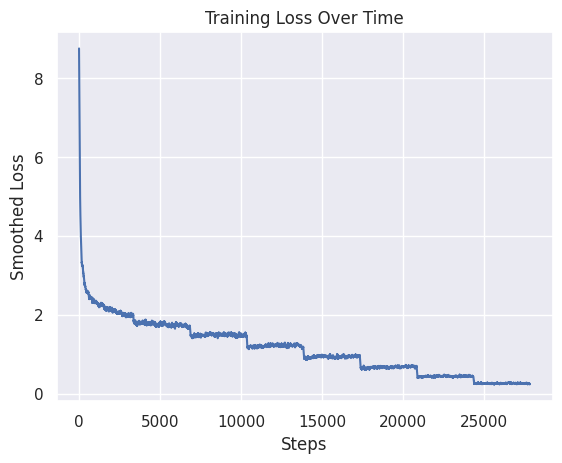

In [21]:
fine_tune_and_save_model(model, tokenizer, small_data_set['train'], small_data_set['validation'], LANG_TOKEN_MAPPING, './mt5_fine_tune_eng_hindi')

In [22]:
save_fine_tuned_model(model, tokenizer, './mt5-small_fine_tune_eng_hindi')

In [23]:
model, tokenizer = load_fine_tuned_model('./mt5-small_fine_tune_eng_hindi')

In [24]:
# Example usage
#test_sentence = small_data_set['train']['translation'][0]['en']
test_sentence = "Stop in the name of the law"
print('Raw input text:', test_sentence)

translated_text = translate_text(
    input_text=test_sentence,
    model=model,
    tokenizer=tokenizer,
    target_lang='hi',
    lang_token_map=LANG_TOKEN_MAPPING,
    seq_len=model.config.max_length
)

print('Translated text:', translated_text)

In [25]:
# Prepare the test data
test_data, tokenized_test_data = prepare_test_data(small_data_set, tokenizer, num_examples=100)

# Perform translation testing
translated_test_data = perform_translation_testing(model, tokenizer, test_data, tokenized_test_data, target_lang="hi")

# Evaluate translations using BERTScore
evaluate_translations_bertscore(test_data, translated_test_data)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# Evaluate translations using BLEU score
evaluate_translations_bleu(test_data, translated_test_data, tokenizer)

# Evaluate translations using ROUGE score
evaluate_translations_rouge(test_data, translated_test_data, tokenizer)

# Evaluate translations using METEOR score
evaluate_translations_meteor(test_data, translated_test_data, tokenizer)